pscp C:\Users\lab414\Desktop\image.zip user@140.124.44.41:/home/user/test

In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import os
os.environ['CUDA_VISIBLE_DEVICES']= '0'

In [2]:
DATA_DIR = '/home/user/test'

# Directory to save logs and trained model
ROOT_DIR = '/home/user/Desktop/working/ng'

In [3]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
train_dicom_dir = os.path.join(DATA_DIR, 'image')
#test_dicom_dir = os.path.join(DATA_DIR, 'image')

In [6]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if __debug__ else 150
    VALIDATION_STEPS = 10 if __debug__ else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()

In [7]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction


In [8]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(train_dicom_dir) if f not in exclude_list]
#test_names = [f for f in os.listdir(test_dicom_dir) if f not in exclude_list]

#print(len(train_names), len(test_names))

In [9]:
# training dataset
SEGMENTATION = DATA_DIR + '/test1.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

,ImageId,EncodedPixels
0,0a8d5d261.jpg,209035 2 209803 5 210570 9 211338 12 212106 15...


In [10]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships

#test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
#image_fps_train, image_fps_val = train_test_split(train_names, test_size=0, random_state=42)

#if __debug__:
#    image_fps_train = image_fps_train[:100]
#    image_fps_val = image_fps_val[:100]
#    test_names = test_names[:100]
    
#print(len(image_fps_train), len(image_fps_val), len(test_names))

In [11]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(train_dicom_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [12]:
image_fps, image_annotations = train_names, anns
len(image_fps)

1

In [13]:
#%%time
# prepare the training dataset
dataset_train = DetectorDataset(train_names, image_annotations, 768, 768)
dataset_train.prepare()

/home/user/test/image/0a8d5d261.jpg


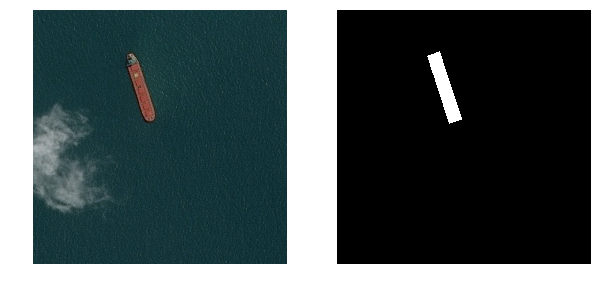

In [15]:
class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    for i in range(1): ##Have ship
        image_id = i
        image_fp = dataset_train.image_reference(image_id)
        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)
        cv2.imwrite('/home/user/test/%s.jpg' %(i), image)
        masked = np.zeros(image.shape[:2])
        for k in range(mask.shape[2]):
            masked += mask[:, :, k] 
        cv2.imwrite('/home/user/test/mask_%s.jpg' %(i), masked.astype('uint8') * 255)
   
        #print(image.shape)
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        masked = np.zeros(image.shape[:2])
        for i in range(mask.shape[2]):
            masked += mask[:, :, i] ## * image[:, :, 0]
        plt.imshow(masked, cmap='gray')
        plt.axis('off')

        print(image_fp)
        #print(class_ids)